<a href="https://colab.research.google.com/github/hyeongaa/hyss/blob/main/second.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

딥러닝을 이용하여 사진이 어떤 것인지 컴퓨터의 눈으로 확인하는 법을 해볼 거에요!

# 당연히 어렵고, 처음해본 사람이 할 수는 없습니다! 하지만, 체험이라고 생각해보고 컴퓨터 공학이나 공대에서는 이런 것을 하는구나 생각하면서 이해하려고 하지말고!!  신기하게 바라보면 됩니다~~!!







.



처음에는 이러한 딥러닝을 하기 위해서 세팅을 하는 것인데요!! 

예를 들어 우리가 파스타를 만들려고 한다면 그에 맞는 재료와 요리기구를 준비해야겠죠! 그러한 과정을 하는 것이라고 생각하시면 됩니다!

In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

import os, sys
import tarfile
import time
import random
import pickle
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print("OpenCV-Python Version %s" % cv2.__version__)



!pip install -U --no-cache-dir gdown --pre
!gdown --fuzzy 'https://drive.google.com/file/d/1fAjSR-Vkl6LvlK0G2OZPrsVAoQwijRpx/view?usp=sharing'

caltech_url = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'
caltech_filename = '101_ObjectCategories.tar.gz'
caltech_dir = '101_ObjectCategories/'

numTrain = 15
numTest = 15
numClasses = 102
numWords = 600

vocabPath = 'vocab.pkl'
svmPath = os.path.join(caltech_dir, 'svm_data.dat')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.0 MB 1.6 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 30.6 MB 11.2 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.3

## 딥러닝은 간단하게 컴퓨터가 배우는 것이라고 생각하면 됩니다. 우리가 사과 사진을 보고 이것이 사과라고 생각하는 것처럼, 컴퓨터에게도 이런 배움의 시간을 줘야겠죠?

그 전에 컴퓨터가 공부하기 위한 자료를 제공해야겠죠? 자료를 다운 받아 봅시다!!

In [ ]:
if not os.path.exists(caltech_dir) or not os.path.exists(os.path.join(caltech_dir, 'airplanes')):
    print('Extracting Caltech-101')
    with tarfile.open(caltech_filename) as tar:
        tar.extractall()

print('Caltech-101 dataset checked')

Extracting Caltech-101
Caltech-101 dataset checked


### 컴퓨터가 이런 사진을 보고 공부하는 것이에요!!

Select 15 train/test images for each class
done


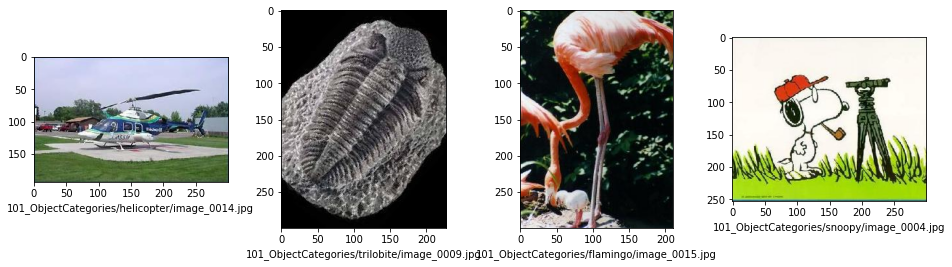

In [ ]:

print('Select 15 train/test images for each class')
classes = next(os.walk(caltech_dir))[1]
train_image_ll = []
test_image_ll = []
for c in classes:
    class_dir = os.path.join(caltech_dir, c, '*.jpg')
    ims = glob(class_dir)
    ims.sort()
    train_image_ll.append([f for f in ims[:numTrain]])
    test_image_ll.append([f for f in ims[numTrain:numTrain+numTest]])
print('done')


plt.figure(figsize=(16,4))
for i, idx in enumerate(random.sample(range(len(classes)), 4)):
    fpath = random.sample(train_image_ll[idx], 1)[0]
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel(fpath)
plt.show()

다음 과정은 사실 조금 어려운 과정인데요! 

간단하게 컴퓨터가 공부하기 쉽게 저희가 자료를 조금 쪼개주는 것입니다!

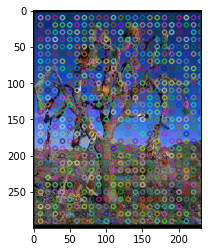

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()

# Resize a image if it's too large
def standarizeImage(img):
    rows, cols = img.shape
    if cols > 480:
        img = cv2.resize(img, (480, int(rows*480/cols)))
    return img

# Detect and extract SIFT from a single image
def SIFT(img):
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

# Load an image + Resize if large + Extract SIFT
def SIFT2(img_fpath):
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    return SIFT(img)

# Dense SIFT(Extract SIFT descriptor in grid points over an image)
def denseSIFT(img, step = 10, size = 7):
    rows, cols = img.shape[:2]
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    return kp, des

# Load an image + Resize if large + Dense SIFT
def denseSIFT2(img_fpath, step = 10):
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    return denseSIFT(img, step)

# Dense SIFT
tmp_im = cv2.cvtColor(cv2.imread(train_image_ll[0][0]), cv2.COLOR_BGR2RGB)
#kp, des = SIFT(tmp_im)
kp, des = denseSIFT(tmp_im)
im_sift = cv2.drawKeypoints(tmp_im, kp, None)
plt.imshow(im_sift) # image is already converted to RGB, do not convert again
plt.show()

컴퓨터에게 단어를 학습 시키는 과정이에요!!

In [ ]:
!wget https://raw.githubusercontent.com/bckim92/iab_practice_example/master/vocab.pkl


if not os.path.exists(vocabPath):
    # Get PHOW features from 30 random training image to build a dictionary
    print("Extracting PHOW features some training images...")
    PHOW_descrs = []
    temp = [item for sublist in train_image_ll for item in sublist]
    '''
    # above line is same function as below lines
    temp = []
    for sublist in train_image_ll:
        for item in sublist:
            temp.append(item)
    '''
    temp = random.sample(temp, 30)
    for fpath in temp:
        _, des = denseSIFT2(fpath)
        PHOW_descrs.append(des)
    PHOW_descrs = np.concatenate(PHOW_descrs, axis=0)
    print("Total {} PHOW features".format(PHOW_descrs.shape[0]))
    
    # Quantize the descriptors to get the visual words
    print("Running K-means clustering ({} -> {})...".format(PHOW_descrs.shape[0], numWords))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 1.0)
    attempts = 1
    flags = cv2.KMEANS_RANDOM_CENTERS
    start_time = time.time()
    retval, bestLabels, vocab = cv2.kmeans(PHOW_descrs, numWords, None, criteria, attempts, flags)
    print('Elapsed time: {:6}s'.format(time.time() - start_time))
    
    print('Saving...') 
    with open(vocabPath, 'wb') as fd:
        pickle.dump(vocab, fd)
    import collections
    myCounter = collections.Counter(bestLabels.flatten())
    plt.plot(sorted(myCounter.values()))
else:
    print("Load the trained visual words...")
    with open(vocabPath, 'rb') as fd:
        vocab = pickle.load(fd)

print('Done!')

--2022-07-02 17:53:08--  https://raw.githubusercontent.com/bckim92/iab_practice_example/master/vocab.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 307361 (300K) [application/octet-stream]
Saving to: ‘vocab.pkl’

vocab.pkl           100%[===================>] 300.16K  --.-KB/s    in 0.03s   

2022-07-02 17:53:08 (9.09 MB/s) - ‘vocab.pkl’ saved [307361/307361]

Load the trained visual words...
Done!


# 이제 부터는 컴퓨터가 이 단어와 그림들을 스스로 공부할 수 있게 도와주는 과정입니다!!
 한번 보기만 해보세요!!

In [ ]:
bf = cv2.BFMatcher()

def getImageDescriptor(img, step=10, size=7):
    img = standarizeImage(img)
    cols, rows = img.shape[:2]
    
    # Extracting denseSIFT and BoW
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    matches = bf.knnMatch(des, vocab, k=1)
    words = [m[0].trainIdx for m in matches]
    
    # Spatial Binning - 2x2
    binX = 2
    binY = 2
    temp = np.zeros((binX, binY, numWords), dtype=np.float32)
    for k, w in zip(kp, words):
        i = int((k.pt[0]) * binX / cols)
        j = int((k.pt[1]) * binY / rows)
        temp[i, j, w] += 1
    for i in range(binX):
        for j in range(binY):
            temp[i, j, :] /= np.sum(temp[i, j, :])
    temp = temp.flatten()
    hist = temp
    
    binX = 4
    binY = 4
    temp = np.zeros((binX, binY, numWords), dtype=np.float32)
    for k, w in zip(kp, words):
        i = int((k.pt[0]) * binX / cols)
        j = int((k.pt[1]) * binY / rows)
        temp[i, j, w] += 1
    for i in range(binX):
        for j in range(binY):
            temp[i, j, :] /= np.sum(temp[i, j, :])
    temp = temp.flatten()
    hist = temp
    #temp = None
    hist = np.concatenate((hist, temp), axis=0)

    
    hist /= np.sum(hist)
    return hist    


print('Extract spartial histogram for all training images')
BoW_train_ll = []
for c, image_list in zip(classes, train_image_ll):
    print(c) 
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        temp.append(getImageDescriptor(img))
    BoW_train_ll.append(temp)

print('\ndone!')

Extract spartial histogram for all training images
joshua_tree
revolver
mayfly
garfield
saxophone
lobster
Faces_easy
stapler
wheelchair
cup
BACKGROUND_Google
bass
snoopy
barrel
accordion
watch
dollar_bill
starfish
panda
chair
gerenuk
brain
mandolin
scorpion
helicopter
kangaroo
ferry
crocodile
rooster
wild_cat
headphone
beaver
inline_skate
chandelier
car_side
dolphin
dragonfly
Faces
Leopards
butterfly
pyramid
camera
hawksbill
euphonium
stegosaurus
platypus
soccer_ball
crayfish
umbrella
flamingo
elephant
metronome
hedgehog
dalmatian
llama
strawberry
cougar_face
airplanes
Motorbikes
flamingo_head
ant
pizza
grand_piano
gramophone
windsor_chair
ceiling_fan
emu
crocodile_head
nautilus
ewer
brontosaurus
lotus
stop_sign
bonsai
trilobite
cannon
water_lilly
scissors
binocular
cellphone
minaret
crab
pigeon
pagoda
menorah
octopus
lamp
cougar_body
tick
sea_horse
rhino
ketch
yin_yang
wrench
okapi
anchor
buddha
electric_guitar
ibis
schooner
sunflower
laptop

done!


In [ ]:
# Setting training data(BoW, label) for SVM
print('Setting training data(BoW, label) for SVM')
train_bow = []
train_labels = []
numSpartialHist = len(BoW_train_ll[0][0])
for i, BoW_list in enumerate(BoW_train_ll):
    for bow in BoW_list:
        # Hellinger's kernel for each training instance(bow)
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        train_bow.append([temp])
    train_labels.extend([i] * len(BoW_list))
train_bow = np.concatenate(train_bow, axis=0).astype(np.float32)
train_labels = np.array(train_labels, dtype=np.int).reshape((numTrain*numClasses,1))
# => train_bow: (1530, 12000), train_labels: (1530,1)
print("train_bow: ", str(train_bow.shape))
print("train_labels: ", str(train_labels.shape))


print('Training SVM...')
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setC(0.01)
svm.setTermCriteria((cv2.TERM_CRITERIA_COUNT, 10, 1.0))

start_time = time.time()
# svm.train(SVM_train_data)
svm.train(train_bow, cv2.ml.ROW_SAMPLE, train_labels)
print('Elapsed time: {:6}s'.format(time.time() - start_time))

# print 'Saving SVM...'
# svm.save(svmPath)
print('Done!')

Setting training data(BoW, label) for SVM


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


train_bow:  (1530, 19200)
train_labels:  (1530, 1)
Training SVM...
Elapsed time: 32.94501066207886s
Done!


# 이제 컴퓨터가 얼마나 잘 배웠는지 정확도를 봅시다!!

In [ ]:
train_preds = svm.predict(train_bow)[1]
print('Training Accuracy: %.6f' % np.average(train_preds == train_labels))

Training Accuracy: 0.985621


지금까지는 주어진 정답과 그림으로 공부를 하였는데, 이번엔 컴퓨터에게 시험을 보게 할 것입니다!! 얼마나 잘 맞추는 지 확인해봅시다.

In [ ]:
# Extract spartial histogram for all test images
print('Extract spartial histogram for all test images\n')

BoW_test_ll = []

for c, image_list in zip(classes, test_image_ll):
     
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        temp.append(getImageDescriptor(img))
    BoW_test_ll.append(temp)


print('\ndone!')

# Setting test data(BoW, label) for SVM
print('Setting test data(BoW, label) for SVM')
test_bow = []
test_labels = []
numSpartialHist = len(BoW_test_ll[0][0])


numSpartialHist = len(BoW_test_ll[0][0])
for i, BoW_list in enumerate(BoW_test_ll):
    for bow in BoW_list:
        # Hellinger's kernel for each training instance(bow)
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        test_bow.append([temp])
    test_labels.extend([i] * len(BoW_list))
test_bow = np.concatenate(test_bow, axis=0).astype(np.float32)
test_labels = np.array(test_labels, dtype=np.int).reshape((numTest*numClasses,1))




Extract spartial histogram for all test images


done!
Setting test data(BoW, label) for SVM


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


# 정확성을 볼까요?

In [ ]:
test_preds = svm.predict(test_bow)[1]
print('Test Accuracy: {:6}'.format(np.average(test_preds == test_labels)))

### 정말 정확도가 낮죠..? 이 정확도를 높이려고 많은 컴퓨터 공학자들이 연구하고 있습니다!! 

# 한번 여러분이 사진을 넣어서 확인해봅시다!!



In [ ]:
!wget https://raw.githubusercontent.com/bckim92/iab_practice_example/master/images/dragonfly.jpg

--2022-07-02 12:54:09--  https://raw.githubusercontent.com/bckim92/iab_practice_example/master/images/dragonfly.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23885 (23K) [image/jpeg]
Saving to: ‘dragonfly.jpg’

dragonfly.jpg       100%[===================>]  23.33K  --.-KB/s    in 0.001s  

2022-07-02 12:54:10 (16.0 MB/s) - ‘dragonfly.jpg’ saved [23885/23885]



# 인터넷에서 마음에 드는 사진 아무거나 다운받아봅시다!!

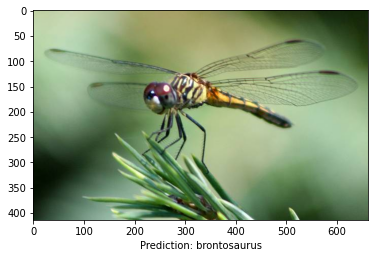

In [ ]:

img_fpath='/content/dragonfly.jpg'
img= cv2.imread('/content/dragonfly.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)




BoW_practice = []
temp = []
temp.append(getImageDescriptor(gray))
BoW_practice.append(temp)


practice_bow = []
practice_labels = []
numSpartialHist = len(BoW_practice[0][0])

for i, BoW_list in enumerate(BoW_practice):
    for bow in BoW_list:

        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        practice_bow.append([temp])
    practice_labels.extend([i] * len(BoW_list))
practice_bow = np.concatenate(practice_bow, axis=0).astype(np.float32)


practice_preds = svm.predict(practice_bow)[1]
prediction=int(practice_preds[0])


plt.imshow(cv2.cvtColor(cv2.imread(img_fpath), cv2.COLOR_BGR2RGB))
plt.xlabel("Prediction: {}".format(classes[prediction]))
plt.show()